**Installing Libraries**

In [1]:
# pandas: A powerful data manipulation and analysis library. Ideal for working with structured data (e.g., CSV files).
# numpy: Fundamental package for numerical computing in Python. It provides arrays, mathematical functions, and more.
# matplotlib: A widely used library for creating static, animated, and interactive visualizations in Python.
# seaborn: Built on top of matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.
# scikit-learn: A comprehensive library for machine learning. It includes tools for classification, regression, clustering, dimensionality reduction, etc.
# textblob: A simple library for processing textual data. Provides basic NLP tasks such as sentiment analysis, translation, and noun phrase extraction.
# transformers: Developed by Hugging Face, it offers state-of-the-art pre-trained models for Natural Language Processing tasks like text classification, summarization, and question answering.
# torch: PyTorch, a deep learning framework used to build and train neural networks. It's especially popular in academic and research communities.

! pip install pandas numpy matplotlib seaborn scikit-learn textblob transformers torch

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.5 MB 4.6 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.5 MB 6.3 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.5 MB 7.5 MB/s eta 0:00:01
   ------------------------- -------------- 7.3/11.5 MB 8.5 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.5 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.6 MB 7.0 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.6 MB 8.7 MB/s eta 0:00:02
   ------------------- -------------------- 6.3/12.6 MB 10.2 MB/s eta 0:00:01
   ---------------------------- ------

**Importing the required libraries**

In [6]:

import pandas as pd  # pandas is used for data manipulation and analysis, especially with tabular data (like CSV files)
import os  # os is used to interact with the operating system, such as creating folders or accessing file paths

# Create folder to save images
# This line creates a folder named 'visuals' in the current working directory if it doesn't already exist.
# 'exist_ok=True' ensures that no error is raised if the folder already exists.
os.makedirs("visuals", exist_ok=True)

# Load the dataset
# Reading a CSV file named 'test.csv' into a pandas DataFrame.
# This assumes that the file is located in the current directory.
df = pd.read_csv("test.csv")

# View the structure of the DataFrame
# Displaying the names of all the columns in the dataset to understand what data is available.
print("Columns:", df.columns.tolist())

# Displaying the first 5 rows of the DataFrame.
# This helps to get a quick preview of the dataset, including column values, types, and missing data if any.
print("\nSample data:")
print(df.head())


Columns: ['Subject', 'body', 'date', 'from']

Sample data:
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  


**Convert 'date' column to datetime format**

In [7]:

# pd.to_datetime() attempts to convert the 'date' column into proper datetime objects.
# The parameter 'errors="coerce"' ensures that any invalid or unrecognizable date strings are converted to NaT (Not a Time) instead of raising an error.
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing dates (i.e., NaT values created due to failed conversions)
# This ensures only rows with valid datetime values are retained for further time-based operations.
df = df.dropna(subset=['date'])

# Extract the month from each date
# .dt.to_period("M") converts each date to a period object representing the month and year (e.g., '2025-05').
# This is useful for grouping data by month later in the analysis.
df['month'] = df['date'].dt.to_period("M")

# Confirm that the time conversion and month extraction have been completed successfully
print("Time column converted and month extracted.")


Time column converted and month extracted.


**classify_sentiment**

Matplotlib is building the font cache; this may take a moment.
C:\Users\HP\AppData\Local\Temp\ipykernel_24216\3881883964.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


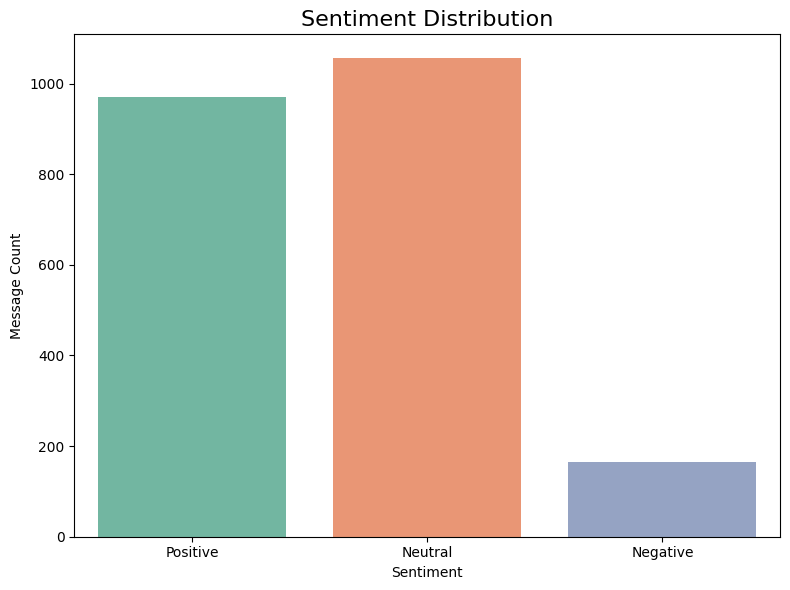

In [8]:
# Importing the required libraries
from textblob import TextBlob  # TextBlob is used here for performing sentiment analysis on text data.
import matplotlib.pyplot as plt  # Matplotlib is a core plotting library used for generating plots and saving images.
import seaborn as sns  # Seaborn is built on top of matplotlib and is used for creating more attractive and readable plots.

# Function to classify sentiment of a given text using TextBlob
def classify_sentiment(text):
    # Convert the input to string and calculate its sentiment polarity.
    # Polarity is a float within the range [-1.0, 1.0], where -1 is very negative, 0 is neutral, and 1 is very positive.
    polarity = TextBlob(str(text)).sentiment.polarity

    # Classify the text based on the polarity score.
    # Thresholds of ±0.1 are used to filter out weak sentiments, ensuring only strongly polar statements are labeled as Positive or Negative.
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classify_sentiment function to the 'body' column of the DataFrame
# Each text entry (assumed to be in a column named 'body') is processed for sentiment.
df['sentiment'] = df['body'].apply(classify_sentiment)

# --- Visualization: Overall Sentiment Distribution ---

# Create a figure with a specified size
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to display the number of messages per sentiment category
# 'palette=Set2' gives the bars distinct colors
sns.countplot(x='sentiment', data=df, palette='Set2')

# Add labels and title to the plot
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Message Count")

# Adjust layout to prevent clipping of labels or titles
plt.tight_layout()

# Save the figure as an image file in the 'visuals' folder
plt.savefig("visuals/sentiment_distribution.png")

# Display the plot in the output window
plt.show()


**Exploratory Data Analysis (EDA):**

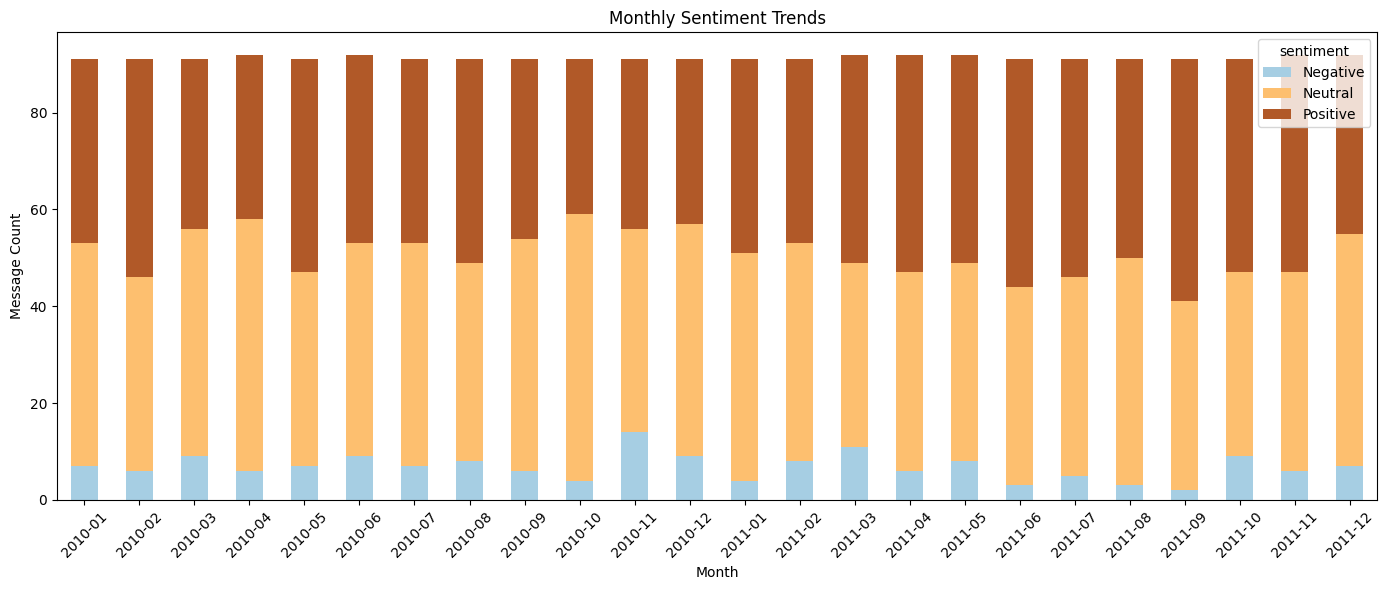

In [9]:
# Grouping the DataFrame by 'month' and 'sentiment'
# This groups the data first by the extracted 'month' (a Period object) and then by the sentiment category (Positive, Negative, Neutral).
# The .size() counts the number of messages in each group.
# .unstack() pivots the sentiment labels to columns, so each month becomes a row with sentiment counts as separate columns.
# .fillna(0) replaces any missing combinations (e.g., if a month had no 'Negative' messages) with 0 to avoid plotting issues.
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

# Visualization: Monthly Sentiment Trend as a Stacked Bar Chart ---

# Plot a stacked bar chart to show sentiment distribution across months
# kind='bar' specifies a vertical bar chart, and stacked=True layers the sentiment types on top of one another.
# figsize sets the dimensions, and colormap assigns distinct colors.
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Paired')

# Add title and axis labels
plt.title('Monthly Sentiment Trends')       # Title of the plot
plt.xlabel('Month')                         # X-axis label (month period)
plt.ylabel('Message Count')                 # Y-axis label (number of messages)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()

# Save the figure as an image to the 'visuals' folder
plt.savefig("visuals/monthly_sentiment_trend.png")

# Display the plot
plt.show()


**Employee Score Calculation**

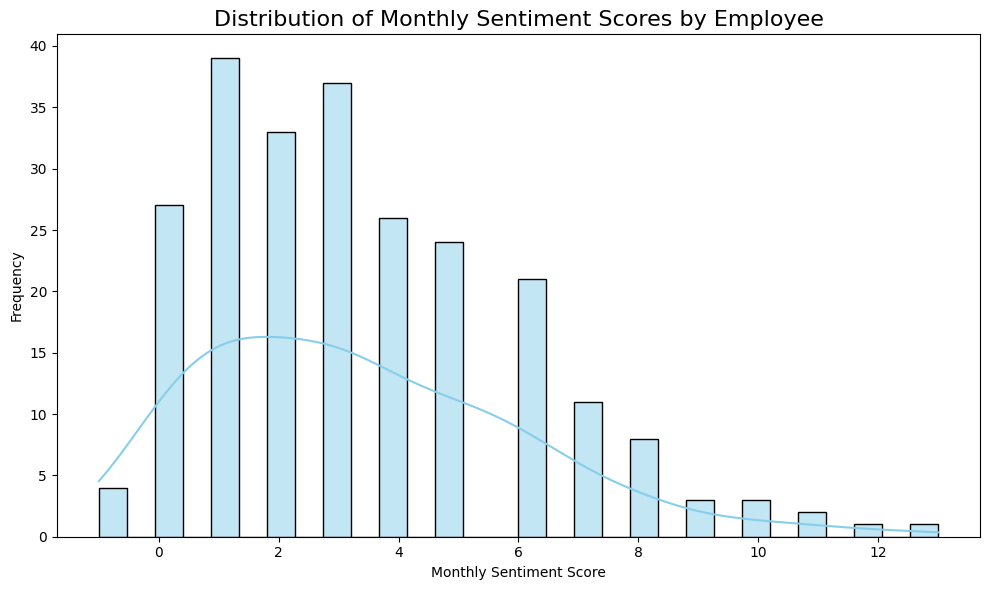

In [11]:
# --- Convert Sentiment Labels to Numerical Scores ---

# Define a dictionary to map sentiment categories to numeric scores
# Positive = +1, Neutral = 0, Negative = -1 — useful for quantifying sentiment
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}

# Create a new column 'score' by mapping sentiment labels using the score_map
# This numeric representation allows statistical analysis and aggregation
df['score'] = df['sentiment'].map(score_map)

# --- Aggregate Sentiment Scores per Employee per Month ---

# Group the data by 'from' (assumed to be the sender/employee) and 'month'
# Then sum the sentiment scores to get a net sentiment score per employee for each month
monthly_scores = df.groupby(['from', 'month'])['score'].sum().reset_index()

# Rename columns for clarity
# 'from' becomes 'employee' for better readability
# 'score' becomes 'monthly_score' to represent the aggregated value
monthly_scores.rename(columns={'from': 'employee', 'score': 'monthly_score'}, inplace=True)

# --- Visualization: Distribution of Monthly Sentiment Scores ---

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a histogram with kernel density estimation (KDE)
# This shows the distribution of monthly sentiment scores across employees
# 'bins=30' provides granularity, 'kde=True' overlays a smoothed curve
sns.histplot(monthly_scores['monthly_score'], bins=30, kde=True, color='skyblue')

# Set plot title and axis labels
plt.title("Distribution of Monthly Sentiment Scores by Employee", fontsize=16)
plt.xlabel("Monthly Sentiment Score")
plt.ylabel("Frequency")

# Adjust layout to avoid label overlap
plt.tight_layout()

# Save the plot as a PNG file in the 'visuals' directory
plt.savefig("visuals/monthly_score_distribution.png")

# Display the plot
plt.show()


**Employee Ranking**

In [15]:
# Initialize an empty dictionary to store top employee data for each month
top_employees = {}

# --- Loop through each unique month in the monthly_scores DataFrame ---
for month in monthly_scores['month'].unique():
    
    # Filter the monthly_scores DataFrame to only include rows for the current month
    month_data = monthly_scores[monthly_scores['month'] == month]

    # Sort by 'monthly_score' in descending order to get the top 3 positive employees
    top_pos = month_data.sort_values(by='monthly_score', ascending=False).head(3)

    # Sort by 'monthly_score' in ascending order to get the top 3 negative employees
    top_neg = month_data.sort_values(by='monthly_score').head(3)

    # Store the top positive and negative performers for this month
    # Convert 'month' to string for dictionary key compatibility
    top_employees[str(month)] = {
        'Top 3 Positive': top_pos[['employee', 'monthly_score']],
        'Top 3 Negative': top_neg[['employee', 'monthly_score']]
    }

# --- Display the top employees for the latest available month ---

# Get the most recent (latest) month
latest_month = str(monthly_scores['month'].max())

# Print the top 3 positive and negative employees for that month
print(f"\nTop Employees for {latest_month}:")

print("\nTop 3 Positive Employees:")
print(top_employees[latest_month]['Top 3 Positive'])

print("\nTop 3 Negative Employees:")
print(top_employees[latest_month]['Top 3 Negative'])



Top Employees for 2011-12:

Top 3 Positive Employees:
                     employee  monthly_score
191  patti.thompson@enron.com              5
143   kayne.coulter@enron.com              5
215   rhonda.denton@enron.com              4

Top 3 Negative Employees:
                        employee  monthly_score
23   bobette.riner@ipgdirect.com              0
95         john.arnold@enron.com              2
167      lydia.delgado@enron.com              2


**Flight Risk Identification**

In [16]:
# --- Step 1: Filter Out Only Negative Sentiment Messages ---

# Select only rows where the sentiment is 'Negative'
# Keep only the columns 'from' (employee ID or name) and 'date' which are relevant for this analysis
negative_msgs = df[df['sentiment'] == 'Negative'][['from', 'date']]

# Initialize an empty set to store employees flagged as flight risk
# A set is used to avoid duplicates automatically
flight_risk = set()

# --- Step 2: For Each Employee, Check for 4 Negative Messages Within 30 Days ---

# Loop through all unique employees who have sent at least one negative message
for emp in negative_msgs['from'].unique():
    
    # Extract and sort the list of negative message dates for the current employee
    emp_dates = negative_msgs[negative_msgs['from'] == emp]['date'].sort_values().reset_index(drop=True)

    # Iterate through the list of dates using a sliding window of 4 messages
    for i in range(len(emp_dates) - 3):  # -3 to leave space for the 4th message in the window
        # Check if 4 consecutive negative messages fall within a 30-day period
        if (emp_dates[i+3] - emp_dates[i]).days <= 30:
            # If condition is met, flag employee as potential flight risk and break to avoid duplicate entries
            flight_risk.add(emp)
            break

# --- Step 3: Print the Set of Flight Risk Employees ---

print("\n Flight Risk Employees:")
print(flight_risk)



 Flight Risk Employees:
{'bobette.riner@ipgdirect.com', 'lydia.delgado@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'patti.thompson@enron.com', 'sally.beck@enron.com', 'rhonda.denton@enron.com'}


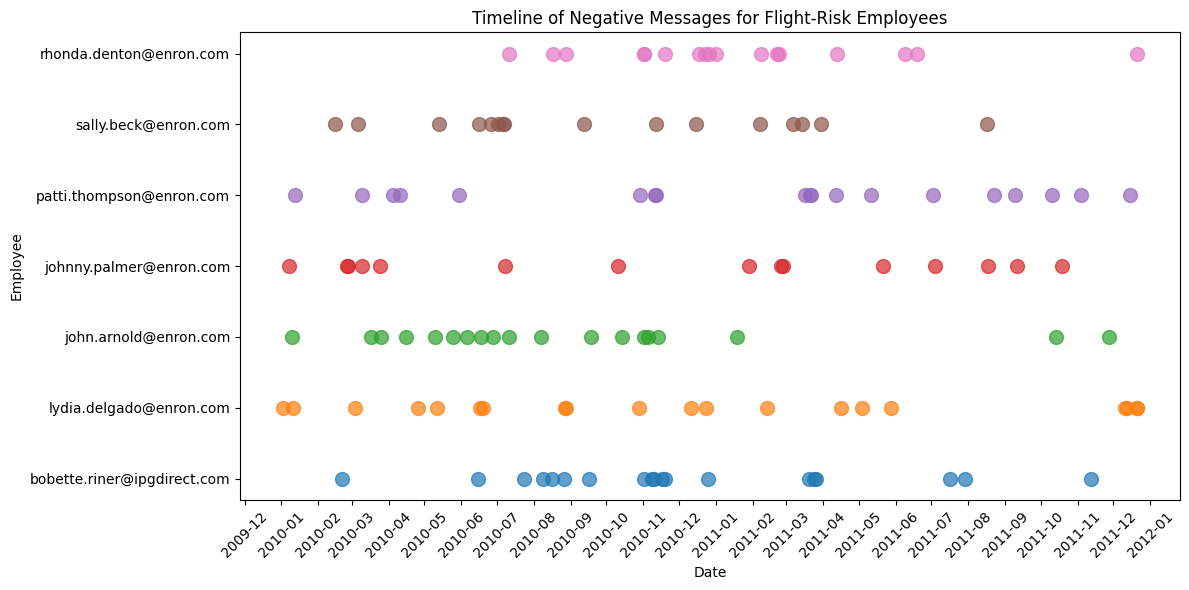

In [17]:
# Import matplotlib's dates module for formatting the x-axis with date labels
import matplotlib.dates as mdates

# --- Initialize Plot ---

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Loop through each employee identified as flight risk
# Enumerate provides a running index (i) which is used to assign y-position for plotting
for i, emp in enumerate(flight_risk):
    
    # Extract the dates of negative messages for this employee
    emp_neg_dates = negative_msgs[negative_msgs['from'] == emp]['date']
    
    # Plot the dates as scatter points along the x-axis, with y-axis value fixed at the employee's index
    # Each dot represents a negative message
    plt.scatter(emp_neg_dates, [i] * len(emp_neg_dates), label=emp, s=100, alpha=0.7)
    # s=100 sets dot size, alpha=0.7 makes them semi-transparent for better visual layering

# Set y-ticks to show employee names (or IDs)
plt.yticks(range(len(flight_risk)), list(flight_risk))

# Add plot title and axis labels
plt.title("Timeline of Negative Messages for Flight-Risk Employees")
plt.xlabel("Date")
plt.ylabel("Employee")

# Format x-axis to show month labels for better time readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set x-ticks to one per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as "YYYY-MM"

# Rotate x-tick labels to prevent overlapping
plt.xticks(rotation=45)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Save the final plot to file
plt.savefig("visuals/flight_risk_timeline.png")

# Display the plot
plt.show()


**Predictive Modeling**


Linear Regression Results:
Mean Squared Error: 7.293
R² Score: -0.040


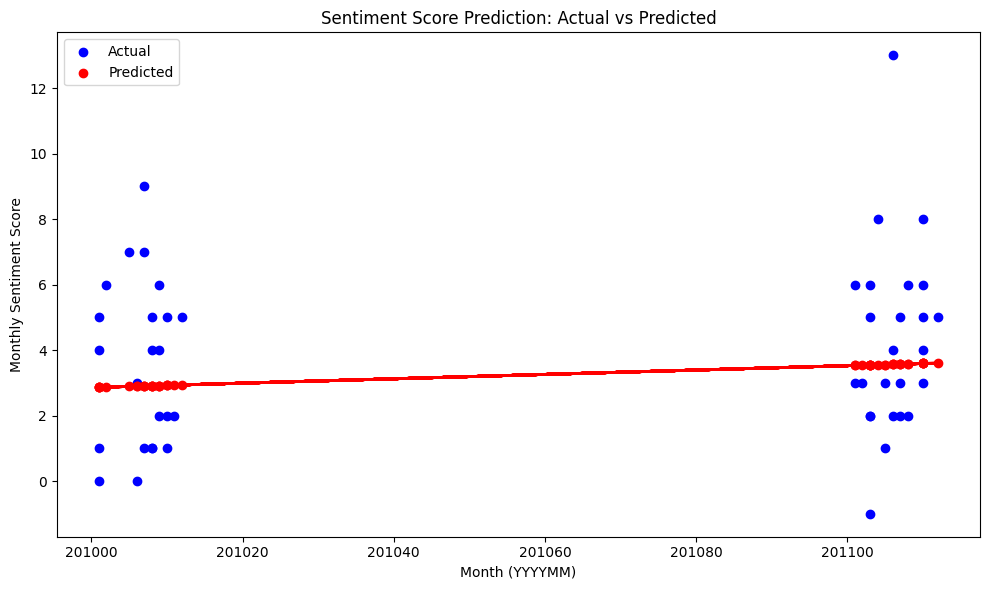

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# --- Data Preparation for Regression ---

# Convert the 'month' Period object to a string and then to an integer in YYYYMM format
# This numeric format is needed for regression as the model expects numerical inputs
monthly_scores['month_int'] = monthly_scores['month'].astype(str).str.replace('-', '').astype(int)

# Define feature matrix X and target vector y
# X is the integer month representation
# y is the monthly aggregated sentiment score
X = monthly_scores[['month_int']]
y = monthly_scores['monthly_score']

# --- Train-Test Split ---

# Split the data into training and testing sets (80% train, 20% test)
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train Linear Regression Model ---

model = LinearRegression()
model.fit(X_train, y_train)  # Fit model on training data

# --- Predict on Test Set ---

y_pred = model.predict(X_test)

# --- Evaluate Model Performance ---

# Calculate Mean Squared Error (MSE): average squared difference between predicted and actual values
print(f"\nLinear Regression Results:\nMean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")

# Calculate R² Score: proportion of variance in target explained by the model (1 is perfect)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

# --- Visualization: Actual vs Predicted Monthly Sentiment Scores ---

plt.figure(figsize=(10,6))

# Scatter plot of actual sentiment scores (blue dots)
plt.scatter(X_test, y_test, color='blue', label='Actual')

# Scatter plot of predicted sentiment scores (red dots)
plt.scatter(X_test, y_pred, color='red', label='Predicted')

# Line plot of predicted scores to show trend
plt.plot(X_test, y_pred, color='red', linewidth=2)

# Add titles and axis labels
plt.title('Sentiment Score Prediction: Actual vs Predicted')
plt.xlabel('Month (YYYYMM)')
plt.ylabel('Monthly Sentiment Score')

plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("visuals/sentiment_score_prediction.png")

# Show the plot
plt.show()


**Create an Excel workbook and write multiple DataFrames to separate sheets**

In [ ]:
# Use pandas ExcelWriter to create an Excel workbook and write multiple DataFrames to separate sheets
with pd.ExcelWriter("Employee_Sentiment_Report.xlsx") as writer:
    
    # Write the raw dataframe with all messages to a sheet named 'Raw_Data'
    # index=False to exclude row numbers in Excel
    df.to_excel(writer, sheet_name='Raw_Data', index=False)
    
    # Write the aggregated monthly sentiment counts (positive, neutral, negative) to 'Monthly_Sentiment'
    monthly_sentiment.to_excel(writer, sheet_name='Monthly_Sentiment')
    
    # Write the monthly sentiment scores per employee to 'Monthly_Scores'
    monthly_scores.to_excel(writer, sheet_name='Monthly_Scores', index=False)

    # For each month, save top 3 positive and negative employees to separate sheets
    for month, data in top_employees.items():
        # Top 3 positive employees for the month
        data['Top 3 Positive'].to_excel(writer, sheet_name=f'{month}_Top_Pos', index=False)
        
        # Top 3 negative employees for the month
        data['Top 3 Negative'].to_excel(writer, sheet_name=f'{month}_Top_Neg', index=False)

# Confirmation message after successful export
print(" Report exported to Employee_Sentiment_Report.xlsx")
